
--- Applying Quantile Scaling (Preprocessing) ---
--- Applying PCA (2 Components) ---


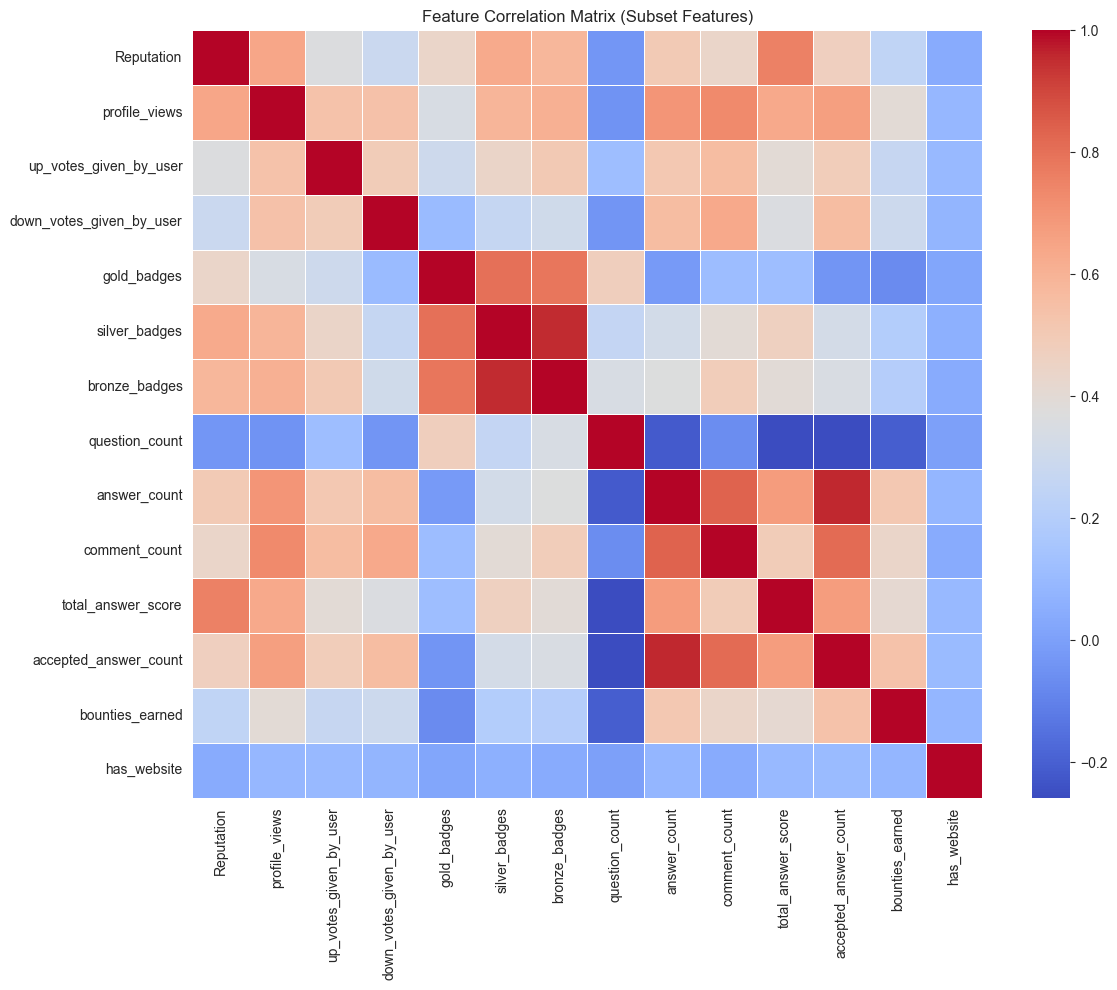


--- Running K-Means Clustering (k=2) ---
Silhouette Score: 0.5868
Davies-Bouldin:   0.7009


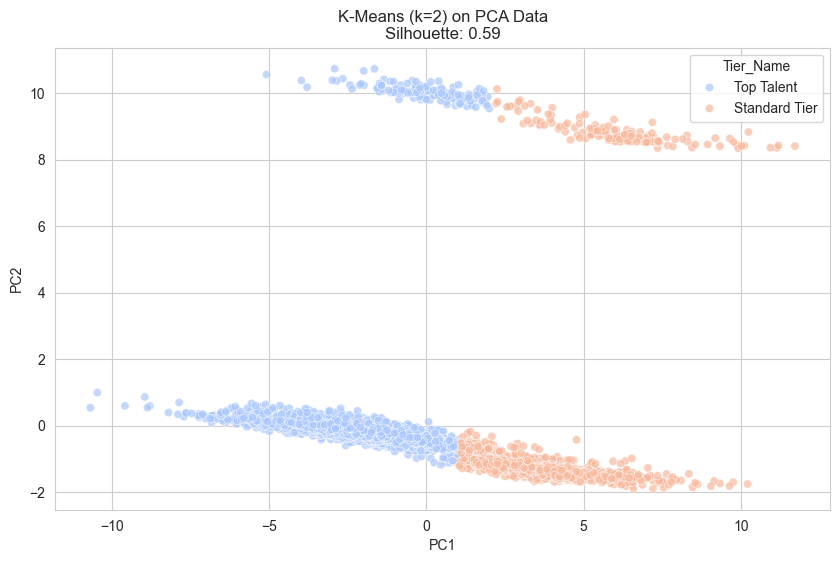


--- Running Logistic Regression (Binary) ---
Accuracy: 0.9970

Classification Report:
              precision    recall  f1-score   support

    Standard       1.00      0.99      1.00       310
  Top Talent       1.00      1.00      1.00       690

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



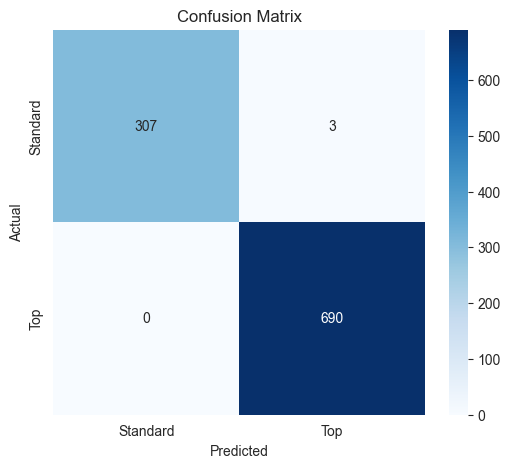

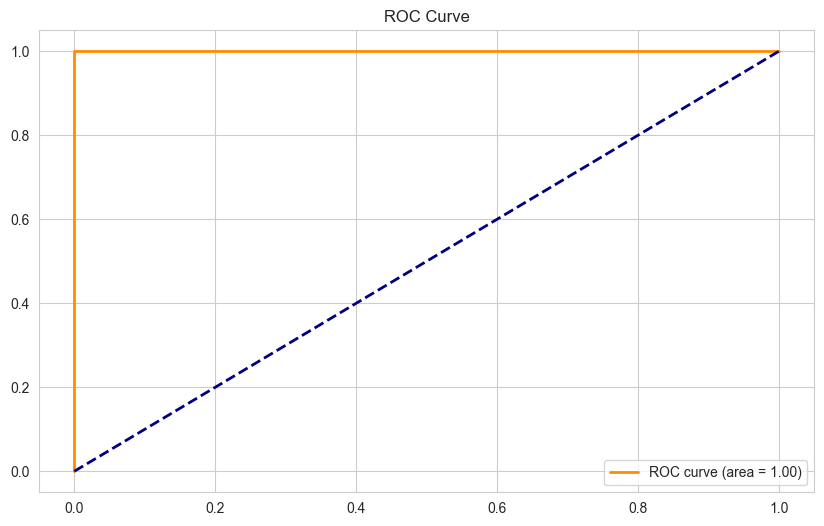


--- Top 10 Ranked Candidates (SOTS Scaled 0-100) ---
 user_id      DisplayName  Reputation Cluster_Label                     SOTS
   22656        Jon Skeet     1523453    Top Talent 100.00000000000000000000
   17034     Hans Passant      946973    Top Talent  99.99097353349395689293
    6309             VonC     1365445    Top Talent  99.94196377687623566999
 1144035    Gordon Linoff     1276212    Top Talent  99.91004517920868011061
  157882           BalusC     1115076    Top Talent  99.90366998755938254817
  100297  Martijn Pieters     1139881    Top Talent  99.90003082255098831865
  115145      CommonsWare     1011523    Top Talent  99.84748918269710316054
 3832970 Wiktor Stribiżew      631314    Top Talent  99.82143337319764953008
   23354     Marc Gravell     1071509    Top Talent  99.82110694985149734748
  157247     T.J. Crowder     1082564    Top Talent  99.80467917120591891944


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             silhouette_score, davies_bouldin_score, roc_curve, auc)

# Set visual style
sns.set_style("whitegrid")

# ---------------------------------------------------------
# 1. LOAD & PREPROCESS DATA
# ---------------------------------------------------------
try:
    df = pd.read_csv('so_raw.csv')
except FileNotFoundError:
    print("File not found. Please ensure 'so_raw.csv' is in the working directory.")
    # Dummy data generation
    np.random.seed(42)
    data = {
        'user_id': range(1, 1001),
        'DisplayName': [f'User_{i}' for i in range(1, 1001)],
        'Reputation': np.concatenate([np.random.exponential(500, 800), np.random.exponential(10000, 200)]),
        'up_votes_given_by_user': np.random.randint(0, 500, 1000),
        'profile_views': np.random.randint(0, 10000, 1000),
        'total_answer_score': np.random.normal(50, 20, 1000)
    }
    df = pd.DataFrame(data)

metadata = df[['user_id', 'DisplayName', 'Reputation']].copy()

features_drop = ['user_id', 'DisplayName', 'CreationDate', 'LastAccessDate', 'Location', 'AboutMe', 'WebsiteUrl','bio_length']
X_raw = df.drop(columns=features_drop, errors='ignore').select_dtypes(include=[np.number])

# Handle NaNs
X_raw = X_raw.fillna(0)
X_clean = np.nan_to_num(X_raw, posinf=0, neginf=0)
X_df = pd.DataFrame(X_clean, columns=X_raw.columns)

# --- PREPROCESSING SCALER ---
print("\n--- Applying Quantile Scaling (Preprocessing) ---")
# Using Normal distribution here to help PCA/KMeans
qt_pre = QuantileTransformer(output_distribution='normal', random_state=42)
X_scaled = pd.DataFrame(qt_pre.fit_transform(X_df), columns=X_df.columns)

# --- APPLY PCA ---
print("--- Applying PCA (2 Components) ---")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])


# 3. CORRELATION MATRIX (Original Viz)
# ---------------------------------------------------------
plt.figure(figsize=(12, 10))
corr_matrix = X_scaled.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix (Subset Features)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 2. UNSUPERVISED: K-MEANS (k=2)
# ---------------------------------------------------------
print("\n--- Running K-Means Clustering (k=2) ---")
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
raw_labels = kmeans.fit_predict(X_pca_df)

# Map Labels
df['Temp_Cluster'] = raw_labels
cluster_quality = df.groupby('Temp_Cluster')['Reputation'].median().sort_values()
rank_map = {old_label: new_rank for new_rank, old_label in enumerate(cluster_quality.index)}

df['Tier_Rank'] = df['Temp_Cluster'].map(rank_map)
df['Tier_Name'] = df['Tier_Rank'].map({0: 'Standard Tier', 1: 'Top Talent'})

# --- METRICS ---
sil_score = silhouette_score(X_pca_df, df['Tier_Rank'])
db_score = davies_bouldin_score(X_pca_df, df['Tier_Rank'])
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin:   {db_score:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue=df['Tier_Name'], data=X_pca_df.join(df['Tier_Name']), palette='coolwarm', alpha=0.7)
plt.title(f'K-Means (k=2) on PCA Data\nSilhouette: {sil_score:.2f}')
plt.show()

# ---------------------------------------------------------
# 3. SUPERVISED: LOGISTIC REGRESSION
# ---------------------------------------------------------
print("\n--- Running Logistic Regression (Binary) ---")

y = df['Tier_Rank']
X_train, X_test, y_train, y_test = train_test_split(X_pca_df, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# --- METRICS ---
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Standard', 'Top Talent']))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Standard', 'Top'], yticklabels=['Standard', 'Top'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_val = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# ---------------------------------------------------------
# 4. FINAL SCORING: SOTS (Quantile Scaled)
# ---------------------------------------------------------
# 1. Get raw Probabilities
final_probs = log_reg.decision_function(X_pca_df)

final_df = metadata.copy()
final_df['Cluster_Label'] = df['Tier_Name']

# 2. Apply QuantileTransformer (Uniform)
# This forces the scores to spread out evenly between 0 and 1 (Percentile Rank),
# creating distinct values even if raw probabilities are clumped.
n_q = min(len(final_df), 1000) # Ensure n_quantiles isn't larger than dataset
scaler = QuantileTransformer(output_distribution='uniform', n_quantiles=n_q, random_state=42)

# Transform to 0-1, then multiply by 100 for SOTS
final_df['SOTS'] = scaler.fit_transform(final_probs.reshape(-1, 1)) * 100

# 3. Sort
ranked_candidates = final_df.sort_values(by='SOTS', ascending=False)

print("\n--- Top 10 Ranked Candidates (SOTS Scaled 0-100) ---")
# 4. Print with 20 decimals
print(ranked_candidates[['user_id', 'DisplayName', 'Reputation', 'Cluster_Label', 'SOTS']]
      .head(10)
      .to_string(index=False, formatters={'SOTS': '{:.20f}'.format}))

In [5]:
df_fff = pd.concat([ranked_candidates,df], axis=1)
df_fff.head(10)
df_fff.to_csv("SO_FINAL.csv", index=False)